# **GSoC 2024 QMLHEP Task III**
---

## **Applying Quantum Generative Adversarial Networks (qGANs) in Monte Carlo Simulations**
In this task, the main objective is to reproduce the results presented in the paper titled "Quantum Generative Adversarial Networks for learning and loading random distributions" authored by Christa Zoufal, Aurélien Lucchi and Stefan Woerner and implement this knowledge to enhance Monte Carlo simulations through the integration of qGANs


#### **Resources**
* [Tensor Flow Quantum Research tool](https://www.tensorflow.org/quantum/tutorials/research_tools)
* [Quantum Generative Adversarial Networks for learning and loading random distributions](https://rdcu.be/dCWcM)

##### *Required libraries*

In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import time
#import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

2024-04-02 11:33:24.116230: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-02 11:33:31.082977: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


---
# **Real Data Generation**
---
In [Zoufal et al](https://rdcu.be/dCWcM), they considered a quantum generator acting on $n=3$ qubits, which can represent $2^3 = 8$ values. The method is applied for 20000 samples of, first, a log-normal distribution with $\mu = 1$ and $\sigma = 1$, second, a triangular distribution
with lower limit $l = 0$, upper limit $u = 7$ and mode $m = 2$, and last,
a bimodal distribution consisting of two superimposed Gaussian
distributions with $\mu_{1} = 0.5$, $\sigma_{1} = 1$ and $\mu_{2} = 3.5$, $\sigma_{2} = 0.5$, respectively. All distributions are truncated to $[0, 7]$ and the samples were rounded to integer values. For simplicity, in this work is only usen a log normal distribution

In [51]:
def expectation_values(data):
    """A helper to get the expected value of each auxiliar qubit"""
    unique_values, counts = np.unique(data, return_counts=True)
    rf= counts/len(data)

    q0 = rf[1] + rf[2] + rf[3] + rf[4] + rf[5] + rf[6] + rf[7] - rf[0]        
    q1 = rf[0] + rf[2] + rf[3] + rf[4] + rf[5] + rf[6] + rf[7] - rf[1]        
    q2 = rf[0] + rf[1] + rf[3] + rf[4] + rf[5] + rf[6] + rf[7] - rf[2]   
    q3 = rf[0] + rf[1] + rf[2] + rf[4] + rf[5] + rf[6] + rf[7] - rf[3]     
    q4 = rf[0] + rf[1] + rf[2] + rf[3] + rf[5] + rf[6] + rf[7] - rf[5]       
    q5 = rf[0] + rf[1] + rf[2] + rf[3] + rf[4] + rf[6] + rf[7] - rf[5]    
    q6 = rf[0] + rf[1] + rf[1] + rf[3] + rf[4] + rf[5] + rf[7] - rf[6]    
    q7 = rf[0] + rf[1] + rf[2] + rf[3] + rf[4] + rf[5] + rf[6] - rf[7]  

    return np.array([q0, q1, q2, q3, q4, q5, q6, q7])       

In [4]:
# Generate 20000 samples with log-normal distribution
log_normal = np.random.lognormal(mean=1, sigma=1, size = 40000)
integer_log_normal = np.round(log_normal)
truncated_log_normal = log_normal[log_normal < 7.5]
log_normal = np.round(truncated_log_normal[:20000])


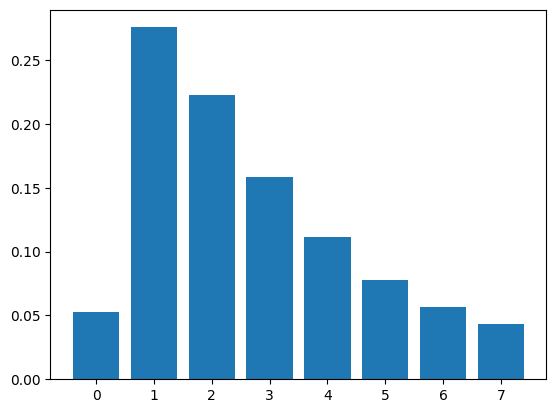

In [5]:
# Show log-normal distribution
plt.hist(log_normal, bins=8, align='left', range=[0, 8], rwidth=0.8, density=True )
plt.show()

---
# **Quantum Generator**
---
In [Zoufal et al](https://rdcu.be/dCWcM), the generator's input state $\ket{\psi_{in}}$ is prepared according to a discrete uniform distribution, this is done by applying a Hadamard gate on each qubit. They also use a normal distribution, nevertheless, in this work only a uniform distribution is used to prepare the the generator's input state $\ket{\psi_{in}}$

In [21]:

def uniform_distribution_preparation(qubits):
    """Create a circuit with a hadamard gate applied on each qubit"""
    initial_state = cirq.Circuit()
    initial_state.append(cirq.H.on_each(qubits))
    return initial_state

The quantum generator is implemented in a variational form just as [Zoufal et al](https://rdcu.be/dCWcM) did. The parametrized circuit consist of alternating layers of parametrized Pauli-Y rotations and blocks of controlled-Z-gates called *entanglement blocks* $U_{ent}$. this two layers are considered as a single one. [Zoufal et al](https://rdcu.be/dCWcM) used a parametrized circuit with $k=1, 2, 3$, where $k$ represents the total layers in the circuit. In this work only a circuit with 3 layers was used due to its robustness it has the ability to represent more complex structures. A diagram of the parametrized quantum circuit used in the [Paper](https://rdcu.be/dCWcM) is shown below.
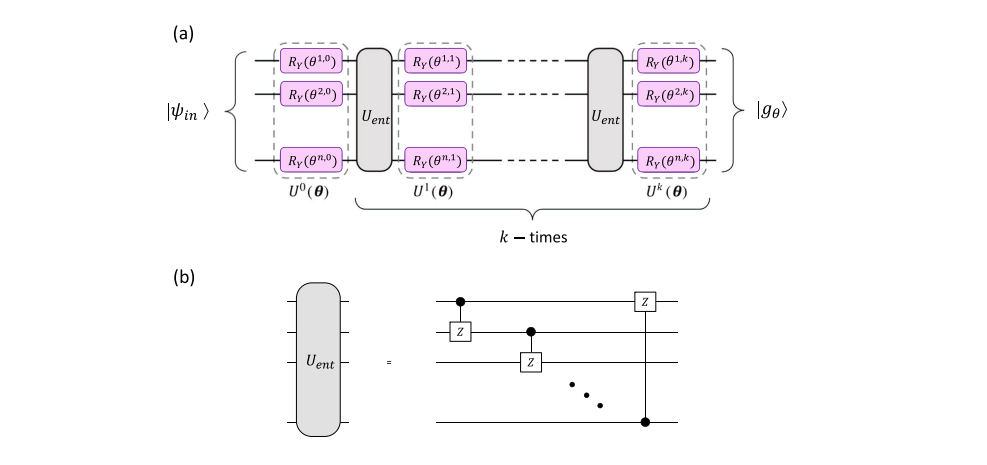


In [22]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, ancilla_qubits):
        self.data_qubits = data_qubits
        self.ancilla_qubits = ancilla_qubits
        self.symbols = []


    def Y_rotations(self, circuit, num_layer):
        """Apply all the Pauli-Y rotations in a layer"""
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol('θ' + str(i) + str(num_layer))
            self.symbols.append(symbol)
            circuit.append(cirq.ry(symbol).on(qubit))

    def entanglement_block(self, circuit):
        """Apply the entanglement blocks to the circuit"""
        for i in range(len(self.data_qubits)):
            if i <= len(self.data_qubits) - 2:
                    circuit.append(cirq.CZ(self.data_qubits[i], self.data_qubits[i+1]))
            else: 
                circuit.append(cirq.CZ(self.data_qubits[i], self.data_qubits[0]))

    def add_layer(self, circuit, num_layer):
         """Add a layer to the circuit"""
         self.entanglement_block(circuit)
         self.Y_rotations(circuit, num_layer)
         

    def add_ancillas(self, circuit):
        """Add auxiliar qubits to the circuit"""
        
        circuit.append(cirq.X(self.ancilla_qubits[7]).controlled_by(*self.data_qubits[0:3]))
        circuit.append(cirq.X(self.data_qubits[0]))
        circuit.append(cirq.X(self.ancilla_qubits[6]).controlled_by(*self.data_qubits[0:3]))
        circuit.append(cirq.X(self.data_qubits[1]))
        circuit.append(cirq.X(self.ancilla_qubits[4]).controlled_by(*self.data_qubits[0:3]))
        circuit.append(cirq.X(self.data_qubits[2]))
        circuit.append(cirq.X(self.ancilla_qubits[0]).controlled_by(*self.data_qubits[0:3]))
        circuit.append(cirq.X(self.data_qubits[0]))
        circuit.append(cirq.X(self.ancilla_qubits[1]).controlled_by(*self.data_qubits[0:3]))
        circuit.append(cirq.X(self.data_qubits[1]))
        circuit.append(cirq.X(self.ancilla_qubits[3]).controlled_by(*self.data_qubits[0:3]))
        circuit.append(cirq.X(self.data_qubits[1]))
        circuit.append(cirq.X(self.data_qubits[2]))
        circuit.append(cirq.X(self.ancilla_qubits[5]).controlled_by(*self.data_qubits[0:3]))
        circuit.append(cirq.X.on_each(self.data_qubits))
        circuit.append(cirq.X(self.ancilla_qubits[2]).controlled_by(*self.data_qubits[0:3]))
        circuit.append(cirq.X(self.data_qubits[0]))
        circuit.append(cirq.X(self.data_qubits[2]))
  

### Parametrized Quantum Circuit
---

In order to train quantum generator, ancilla qubits were added to the parametrized circuit proposed by [Zoufal et al](https://rdcu.be/dCWcM). The aditional qubits were necessary in this implementation due to the output of ```tfq.layers.PQC```, this layer returns the expected values of the readout qubits, with only 3 expected values it is impossible to achieve our goal. Eight ancilla qubits were added to the original circuit and the following series of Controlled-Controlled-PauliX gates were applied to them, when we measure the system we find all the auxiliar qubits in zero state exept that one that represents the state of our original three qubit system.

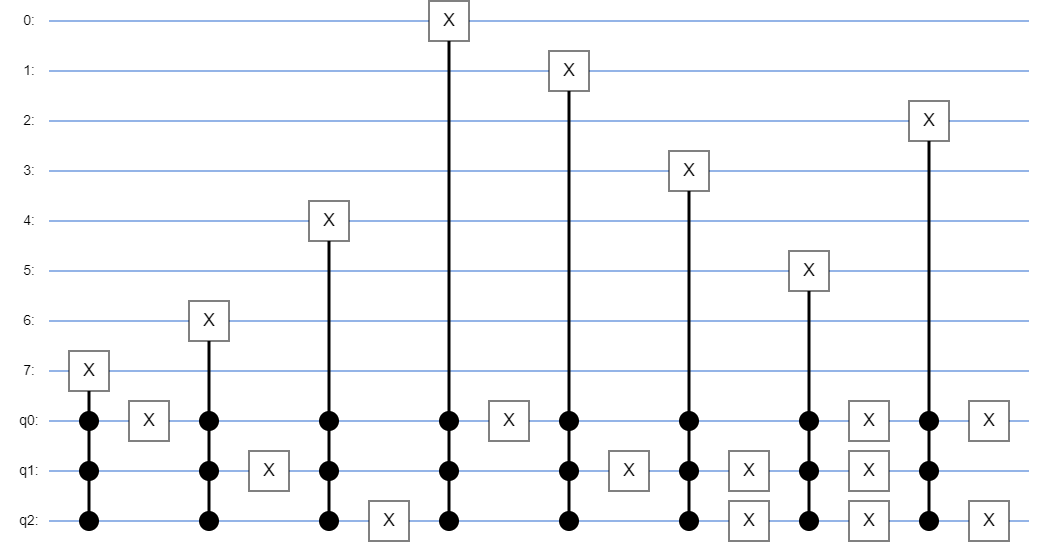

This adition in our circuit allows us to get eight expectation values when we measure the observable Pauli Z, this expectation values are linear combinations of the probabilities to obtain each quantum state when measure the system, the linear combinations are the following:

$$
\begin{aligned}
\text{expval} \ket{ancilla_0} &= -\text{P}(\ket{0}) + \text{P}(\ket{1}) + \text{P}(\ket{2}) + \text{P}(\ket{3}) + \text{P}(\ket{4}) + \text{P}(\ket{5}) + \text{P}(\ket{6}) + \text{P}(\ket{7}) \\
\text{expval} \ket{ancilla_1} &= \text{P}(\ket{0}) - \text{P}(\ket{1}) + \text{P}(\ket{2}) + \text{P}(\ket{3}) + \text{P}(\ket{4}) + \text{P}(\ket{5}) + \text{P}(\ket{6}) + \text{P}(\ket{7}) \\
\text{expval} \ket{ancilla_2} &= \text{P}(\ket{0}) + \text{P}(\ket{1}) - \text{P}(\ket{2}) + \text{P}(\ket{3}) + \text{P}(\ket{4}) + \text{P}(\ket{5}) + \text{P}(\ket{6}) + \text{P}(\ket{7}) \\
\text{expval} \ket{ancilla_3} &= \text{P}(\ket{0}) + \text{P}(\ket{1}) + \text{P}(\ket{2}) - \text{P}(\ket{3}) + \text{P}(\ket{4}) + \text{P}(\ket{5}) + \text{P}(\ket{6}) + \text{P}(\ket{7}) \\
\text{expval} \ket{ancilla_4} &= \text{P}(\ket{0}) + \text{P}(\ket{1}) + \text{P}(\ket{2}) + \text{P}(\ket{3}) - \text{P}(\ket{4}) + \text{P}(\ket{5}) + \text{P}(\ket{6}) + \text{P}(\ket{7}) \\
\text{expval} \ket{ancilla_5} &= \text{P}(\ket{0}) + \text{P}(\ket{1}) + \text{P}(\ket{2}) + \text{P}(\ket{3}) + \text{P}(\ket{4}) - \text{P}(\ket{5}) + \text{P}(\ket{6}) + \text{P}(\ket{7}) \\
\text{expval} \ket{ancilla_6} &= \text{P}(\ket{0}) + \text{P}(\ket{1}) + \text{P}(\ket{2}) + \text{P}(\ket{3}) + \text{P}(\ket{4}) + \text{P}(\ket{5}) - \text{P}(\ket{6}) + \text{P}(\ket{7}) \\
\text{expval} \ket{ancilla_7} &= \text{P}(\ket{0}) + \text{P}(\ket{1}) + \text{P}(\ket{2}) + \text{P}(\ket{3}) + \text{P}(\ket{4}) + \text{P}(\ket{5}) + \text{P}(\ket{6}) - \text{P}(\ket{7}) \\
\end{aligned}
$$

The equation system above has 7 equations and 7 unknown values which are the probabilities of obtain each possible state when measure the observable Pauli Z in the system



In [23]:
def parametrized_quantum_circuit():

    # Prepare the initial state
    qubits = cirq.LineQubit.range(11)
    circuit = uniform_distribution_preparation(qubits[:3])

    # Build the parametrizer quantum circuit
    builder = CircuitLayerBuilder(
        data_qubits = qubits[:3],
        ancilla_qubits = qubits[3:])

    # Add layers
    builder.Y_rotations(circuit, 0)
    builder.add_layer(circuit, 1)
    builder.add_layer(circuit, 2)
    builder.add_layer(circuit, 3)
    
    # Add ancillas
    builder.add_ancillas(circuit)

    return circuit, cirq.Z.on_each(qubits[3:])


In [26]:
model_circuit, model_readout = parametrized_quantum_circuit()

In [27]:
model_circuit

┌────────┐                     ┌────────┐                     ┌────────┐
0: ────H───Ry(θ00)───@────────@───────────Ry(θ01)───@────────@───────────Ry(θ02)───@────────@───────────Ry(θ03)───@───X───@───────@───────@───X───@───────@───────@───X───@───X───
                     │        │                     │        │                     │        │                     │       │       │       │       │       │       │       │
1: ────H───Ry(θ10)───@───@────┼Ry(θ11)──────────────@───@────┼Ry(θ12)──────────────@───@────┼Ry(θ13)──────────────@───────@───X───@───────@───────@───X───@───X───@───X───@───────
                         │    │                         │    │                         │    │                     │       │       │       │       │       │       │       │
2: ────H───Ry(θ20)───────@────@───────────Ry(θ21)───────@────@───────────Ry(θ22)───────@────@───────────Ry(θ23)───@───────@───────@───X───@───────@───────@───X───@───X───@───X───
                                                                                                                  │       │       │       │       │       │       │       │
3: ───────────────────────────────────────────────────────────────────────────────────────────────────────────────┼───────┼───────┼───────X───────┼───────┼───────┼───────┼───────
                                                                                                                  │       │       │               │       │       │       │
4: ───────────────────────────────────────────────────────────────────────────────────────────────────────────────┼───────┼───────┼───────────────X───────┼───────┼───────┼───────
                                                                                                                  │       │       │                       │       │       │
5: ───────────────────────────────────────────────────────────────────────────────────────────────────────────────┼───────┼───────┼───────────────────────┼───────┼───────X───────
                                                                                                                  │       │       │                       │       │
6: ───────────────────────────────────────────────────────────────────────────────────────────────────────────────┼───────┼───────┼───────────────────────X───────┼───────────────
                                                                                                                  │       │       │                               │
7: ───────────────────────────────────────────────────────────────────────────────────────────────────────────────┼───────┼───────X───────────────────────────────┼───────────────
                                                                                                                  │       │                                       │
8: ───────────────────────────────────────────────────────────────────────────────────────────────────────────────┼───────┼───────────────────────────────────────X───────────────
                                                                                                                  │       │
9: ───────────────────────────────────────────────────────────────────────────────────────────────────────────────┼───────X───────────────────────────────────────────────────────
                                                                                                                  │
10: ──────────────────────────────────────────────────────────────────────────────────────────────────────────────X───────────────────────────────────────────────────────────────
                             └────────┘                     └────────┘                     └────────┘

---
# **Training**
---

### Architecture
---

Quantum generator's architecture was explained in the section above, The classical discriminator is implemented using tensorflow, the neural network consist of unique 20-node hidden layer and an Leaky ReLu activation function, followed by a single-node output layer with a sigmoid as activation function.

In [28]:
def quantum_generator_model(repetitions):
    """ Construct quantum generator model"""
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(), dtype=tf.string))
    model.add(tfq.layers.PQC(model_circuit, model_readout, 
                            initializer=tf.keras.initializers.RandomUniform(-np.pi, np.pi),
                            repetitions=repetitions))

    return model

def classical_discriminator_model():
    """Construct classical discriminator model"""
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units = 15, activation='leaky_relu', input_shape=[8]))
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

    return model

In [29]:
discriminator = classical_discriminator_model()
generator = quantum_generator_model(2000)

In [30]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc (PQC)                   (None, 8)                 12        
                                                                 
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


In [31]:
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                135       
                                                                 
 dense_1 (Dense)             (None, 1)                 16        
                                                                 
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


### Loss function
---

Quantum generator's loss function is given by 

$$
\text{L}_{G}(\phi, \theta) = -\frac{1}{m}\sum_{l=1}^m[ln(\text{D}_{\phi}(\text{G}_{\theta}(z^l)))]
$$

and the discriminator's loss function is given by

$$
\text{L}_{D}(\text{D}_\phi,\text{G}_\theta) = -\frac{1}{m}\sum_{l=1}^m[ln(\text{D}_{\phi}(\textbf{x}^l) + ln(1 - \text{D}_{\phi}(\textbf{z}^l)))]
$$

Along with Adam as optimizer

In [32]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_distribution, fake_distribution):
    """ Compute discriminator loss"""
    real_loss = cross_entropy(tf.ones_like(real_distribution), real_distribution)
    fake_loss = cross_entropy(tf.zeros_like(fake_distribution), fake_distribution)
    total_loss = real_loss + fake_loss

    return total_loss

def generator_loss(fake_distribution):
    """Compute generator loss"""
    return cross_entropy(tf.ones_like(fake_distribution), fake_distribution)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [33]:
@tf.function
def train_step(real_expval):
    """Run train step on provided batch"""
    x_train_tf_circuit = tfq.convert_to_tensor([model_circuit for i in range(10)])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_expval = generator(x_train_tf_circuit, training=True)

        real_distribution = discriminator(real_expval, training=True)
        fake_distribution = discriminator(generated_expval, training=True)

        gen_loss = generator_loss(fake_distribution)
        disc_loss = discriminator_loss(real_distribution, fake_distribution)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


### Training data
---

In order to train our QGAN, it is necessary to get the expectation value of each unique value in the log distribution, thus we have used a helper function to compute this expectation values fot the distribution. The data is splitted into batches of 2000 samples each, following the procedure done by [Zoufal et al](https://rdcu.be/dCWcM). Thus, we obtain ten vectors of eight elements containing the expectation value for each possible outcome.

In [35]:
real_samples = np.array_split(log_normal, 10)

batches = []

for sample in range(10):
    sample_expval = expectation_values(real_samples[sample])
    batches.append(sample_expval)

batches = np.array(batches).reshape(10, 8)
batches

array([[0.892 , 0.432 , 0.527 , 0.724 , 0.8205, 0.855 , 0.9145, 0.917 ],
       [0.882 , 0.43  , 0.558 , 0.699 , 0.807 , 0.842 , 0.964 , 0.917 ],
       [0.887 , 0.457 , 0.54  , 0.684 , 0.817 , 0.842 , 0.9295, 0.91  ],
       [0.909 , 0.485 , 0.519 , 0.679 , 0.8115, 0.859 , 0.89  , 0.912 ],
       [0.893 , 0.413 , 0.555 , 0.682 , 0.818 , 0.844 , 0.978 , 0.914 ],
       [0.882 , 0.464 , 0.574 , 0.668 , 0.805 , 0.841 , 0.939 , 0.918 ],
       [0.899 , 0.44  , 0.565 , 0.688 , 0.8045, 0.818 , 0.9545, 0.907 ],
       [0.896 , 0.481 , 0.554 , 0.679 , 0.7985, 0.829 , 0.9245, 0.905 ],
       [0.904 , 0.437 , 0.568 , 0.684 , 0.808 , 0.862 , 0.9425, 0.914 ],
       [0.896 , 0.445 , 0.581 , 0.642 , 0.8165, 0.85  , 0.952 , 0.919 ]])

In [36]:
def train(dataset, epochs, start_epoch=1):
    """Permorm a full training for a given number of epochs"""

    generator_loss = []
    discriminator_loss = []

    batched_data = tf.data.Dataset.from_tensor_slices(dataset).shuffle(10).batch(1)

    for epoch in range(start_epoch, start_epoch+epochs):
        for i, expvals_batch in enumerate(batched_data):
            gl, dl = train_step(expvals_batch)
            
        generator_loss.append(gl)
        discriminator_loss.append(dl)

        print('Epoch {}, discriminator_loss {}, generator_loss {}'.format(epoch, dl, gl))
    
    return generator_loss, discriminator_loss

The model is trained in a minibatch fashion for 1000 epochs

In [37]:
gen_loss, disc_loss = train(batches, epochs=1000)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Epoch 1, discriminator_loss 1.442726492881775, generator_loss 0.44704461097717285
Epoch 2, discriminator_loss 1.4273474216461182, generator_loss 0.4573501646518707
Epoch 3, discriminator_loss 1.4108428955078125, generator_loss 0.4635586738586426
Epoch 4, discriminator_loss 1.4038810729980469, generator_loss 0.4718833565711975
Epoch 5, discriminator_loss 1.4038846492767334, generator_loss 0.4773762822151184
Epoch 6, discriminator_loss 1.3882302045822144, generator_loss 0.4828363060951233
Epoch 7, discriminator_loss 1.378725528717041, generator_loss 0.49037250876426697
Epoch 8, discriminator_loss 1.3753399848937988, generator_loss 0.49743199348449707
Epoch 9, discriminator_loss 1.3759866952896118, generator_loss 0.5017472505569458
Epoch 10, discriminator_loss 1.363538146018982, generator_lo

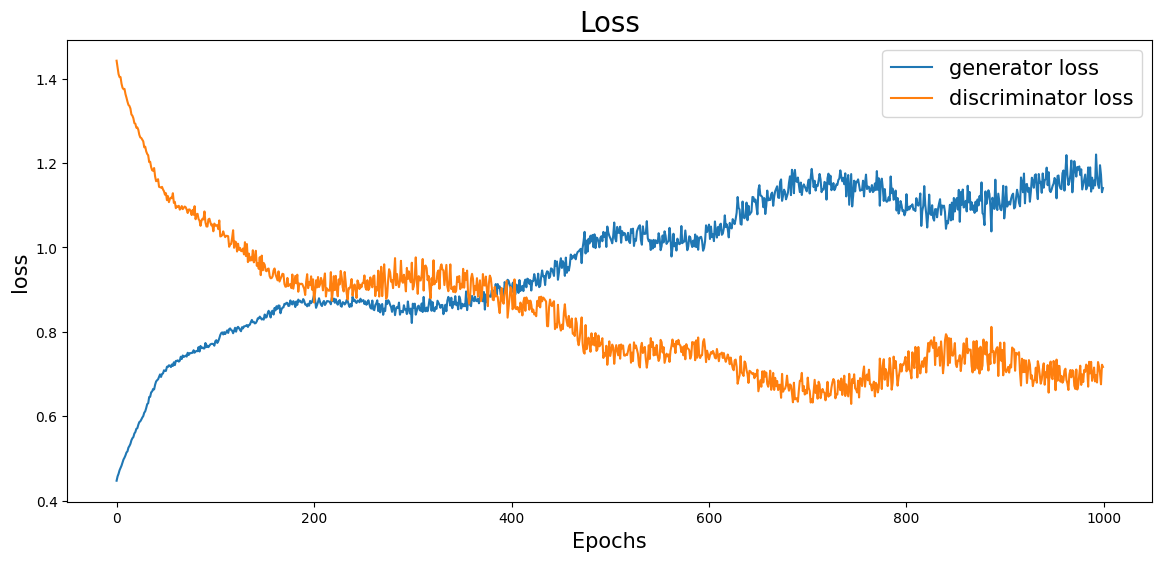

In [48]:
plt.figure(figsize=(14, 6))
plt.plot(gen_loss, label='generator loss')
plt.plot(disc_loss, label = 'discriminator loss')
plt.legend(fontsize=15)
plt.title('Loss', fontsize=20)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('loss', fontsize=15)
plt.show()

---
# **Results**
---

Once trained, we can use the quantum generator alone to predict the expectation values of the trained circuit given a uniform initialized input. As we can see, the expectation values given by the generator are close to those of the log normal distribution although not as close as we wish. 

In [49]:
# generated distribution expectation values
x_train_tf_circuit = tfq.convert_to_tensor([model_circuit for i in range(10)])
generator.predict(x_train_tf_circuit)

1/1 [==============================] - 0s 84ms/step


array([[0.723, 0.403, 0.441, 0.669, 0.629, 0.731, 0.773, 0.777],
       [0.733, 0.392, 0.453, 0.71 , 0.649, 0.715, 0.804, 0.781],
       [0.744, 0.415, 0.459, 0.676, 0.591, 0.734, 0.783, 0.774],
       [0.747, 0.412, 0.429, 0.709, 0.617, 0.729, 0.781, 0.781],
       [0.732, 0.339, 0.488, 0.721, 0.618, 0.722, 0.783, 0.79 ],
       [0.738, 0.373, 0.439, 0.693, 0.655, 0.729, 0.785, 0.794],
       [0.736, 0.428, 0.439, 0.692, 0.641, 0.74 , 0.784, 0.805],
       [0.742, 0.343, 0.462, 0.712, 0.636, 0.751, 0.789, 0.797],
       [0.735, 0.386, 0.456, 0.692, 0.647, 0.729, 0.796, 0.799],
       [0.727, 0.372, 0.421, 0.705, 0.604, 0.727, 0.786, 0.789]],
      dtype=float32)

In [52]:
# Real distribution expectation values
expectation_values(log_normal)

array([0.894  , 0.4484 , 0.5541 , 0.6829 , 0.81065, 0.8442 , 0.93885,
       0.9133 ])

### Problems
---
We would like to see a histogram of a generated distribution, unfortunately here is when the problems come. To do this, we need another generator which only returns the expectation value of a unique measurement, in other words, a single sample of the distribution, then make as many predictions as samples we want 

In [56]:
generator.weights
generator.save_weights('./weights.h5')

# Load the trained weights into another generator which returns a single sample
trained_generator = quantum_generator_model(1)
trained_generator.load_weights('./weights.h5')


In [60]:
x_train_tf_circuit = tfq.convert_to_tensor([model_circuit for i in range(20)])

# Generate samples using the model's predict method
samples = trained_generator.predict(x_train_tf_circuit)
samples



1/1 [==============================] - 0s 24ms/step


array([[ 1., -1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1., -1., -1.,  1.,  1.],
       [ 1., -1.,  1.,  1.,  1., -1.,  1.,  1.],
       [ 1.,  1.,  1.,  1., -1.,  1., -1.,  1.],
       [ 1.,  1., -1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1., -1.,  1.,  1.,  1.],
       [-1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1., -1.,  1., -1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [-1., -1., -1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1., -1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1., -1.,  1., -1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1., -1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1., -1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]], dtype=float32)

The outcome expected is a kind of one-hot encoded vector with $1$ (eigen value of $\ket{0}$ of the Z-Pauli observable) in all entries expect for one with a $-1$ (eigen value of $\ket{1}$ of the Z-Pauli observable). because the final auxiliar circuit used in the generator (shown below) can only return eight posible states which represents the binary number of the original three qubit system. However, when we make predictions sample by sample, we get vectors with more than a $-1$ element or with no $-1$ in it, as is shown above. I am currently not able to explain this bug, but I will be working to find out what is going on.

In [70]:
def get_circuit(bin=[0, 0, 0], eq_sup=False):
    
    qu = cirq.NamedQubit.range(3, prefix='q')
    q = cirq.LineQubit.range(8)
    qubits = qu
    ancilla = q
    circuit = cirq.Circuit()

    for i, bit in enumerate(bin):
        if bit:
            circuit.append(cirq.X(qubits[i]))
    
    if eq_sup:
        circuit.append(cirq.H(qubits[0]))
        circuit.append(cirq.H(qubits[1]))
        circuit.append(cirq.H(qubits[2]))

    circuit.append(cirq.X(ancilla[7]).controlled_by(*qubits))
    circuit.append(cirq.X(qubits[0]))
    circuit.append(cirq.X(ancilla[6]).controlled_by(*qubits))
    circuit.append(cirq.X(qubits[1]))
    circuit.append(cirq.X(ancilla[4]).controlled_by(*qubits))
    circuit.append(cirq.X(qubits[2]))
    circuit.append(cirq.X(ancilla[0]).controlled_by(*qubits))
    circuit.append(cirq.X(qubits[0]))
    circuit.append(cirq.X(ancilla[1]).controlled_by(*qubits))
    circuit.append(cirq.X(qubits[1]))
    circuit.append(cirq.X(ancilla[3]).controlled_by(*qubits))
    circuit.append(cirq.X(qubits[1]))
    circuit.append(cirq.X(qubits[2]))
    circuit.append(cirq.X(ancilla[5]).controlled_by(*qubits))
    circuit.append(cirq.X.on_each(qubits))
    circuit.append(cirq.X(ancilla[2]).controlled_by(*qubits))
    circuit.append(cirq.X(qubits[0]))
    circuit.append(cirq.X(qubits[2]))

    return circuit

circuit = get_circuit(eq_sup=True)
circuit


0: ────────────────────────────────X───────────────────────────────────────
                                   │
1: ────────────────────────────────┼───────X───────────────────────────────
                                   │       │
2: ────────────────────────────────┼───────┼───────────────────────X───────
                                   │       │                       │
3: ────────────────────────────────┼───────┼───────X───────────────┼───────
                                   │       │       │               │
4: ────────────────────────X───────┼───────┼───────┼───────────────┼───────
                           │       │       │       │               │
5: ────────────────────────┼───────┼───────┼───────┼───────X───────┼───────
                           │       │       │       │       │       │
6: ────────────────X───────┼───────┼───────┼───────┼───────┼───────┼───────
                   │       │       │       │       │       │       │
7: ────────X───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────
           │       │       │       │       │       │       │       │
q0: ───H───@───X───@───────@───────@───X───@───────@───────@───X───@───X───
           │       │       │       │       │       │       │       │
q1: ───H───@───────@───X───@───────@───────@───X───@───X───@───X───@───────
           │       │       │       │       │       │       │       │
q2: ───H───@───────@───────@───X───@───────@───────@───X───@───X───@───X───

In [67]:
# Possible outcome states 
final_state_vector = cirq.final_state_vector(circuit)
cirq.dirac_notation(final_state_vector)

'0.35|00000001111⟩ + 0.35|00000010011⟩ + 0.35|00000100101⟩ + 0.35|00001000001⟩ + 0.35|00010000110⟩ + 0.35|00100000010⟩ + 0.35|01000000100⟩ + 0.35|10000000000⟩'

---
# **Further work**
---
The main idea of this task was to implement a trained quantum generator in Monte Carlo simulations. Unfortunately I faced some unexpected troubles and I could not achieve the goal. However I think this could be a good application of QGAN and I have thought further steps to follow in order to complete the task:

* **Improve the implementation**
This implementation has an scalability problem, if we want to quantum generator learning probability distributions with n posible outcomes, we will need n ancilla qubits to train it aside the $\log_2{n}$ qubits of the main circuit, a possible solution is, insted to train the generator using expectations values, it could be trained using samples, thus we only need about $\log_2{n}$ qubits to implement it and train it.

* **Use different frameworks**
This work was done using tensorflow quantum, nevertheless there are many other frameworks specialized in certains tasks, thus, this implementation could be work better bu using another framework